Иморт библиотек и заранее подготовленных данных


importing Jupyter notebook from import_librares.ipynb


c:\course_work\feature_extraction_NLP\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


importing Jupyter notebook from func.ipynb


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chike\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chike\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chike\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chike\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


importing Jupyter notebook from rus_ds_data.ipynb


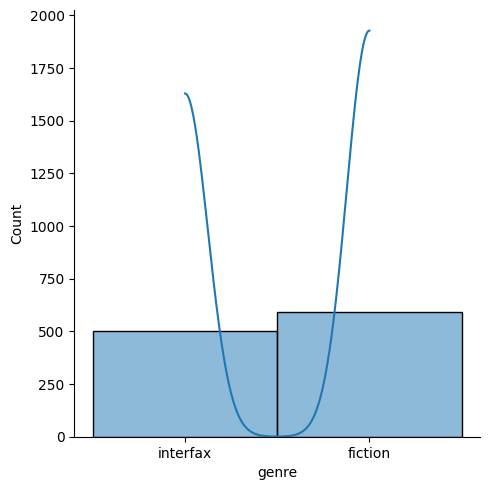

In [1]:
import import_ipynb
import import_librares # ноутбук с импортом библиотек
import func # ноутбук с функциями
import rus_ds_data # ноутбук с загрузкой и предварительной обрабткой русского датасета
from ipynb.fs.full.func import tokenize_morphy, tokenize_lancaster, tokenize_snowball
from sklearn.metrics import accuracy_score

In [2]:
from import_librares import CountVectorizer, TfidfVectorizer, pd, np, plt, train_test_split\
,LogisticRegression, classification_report, roc_auc_score, MaxAbsScaler, GridSearchCV\
,cross_val_score, ppb, Word2Vec

In [3]:
from rus_ds_data import\
    df, Y, df_morphy, df_snowball, df_lancaster\
    , X1, X2, X3, batch1, batch2, batch3

Обучение


In [4]:
X_train, X_test, y_train, y_test = train_test_split(batch2[['text']], batch2['genre'], test_size = 0.3, random_state = 45)

In [5]:
from gensim.models import Word2Vec
sent = [row.split() for row in X_train['text']]

In [6]:
HIDDEN = 100
model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=HIDDEN,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=2)
model.build_vocab(sent, progress_per=10000)
model.train(sent, total_examples=model.corpus_count, epochs=30, report_delay=1)

(27078, 625650)

In [7]:
#счет последнего вектора текста
def get_mean_w2v_vector(sentence):
    Sum = 0
    Count = 0

    try:
      words = sentence.split()
    except TypeError:
      words = []

    for w in words:
        if w in model.wv:
            Sum += model.wv[w]
            # Sum += glove_vectors[w]
            Count += 1

    if Count == 0:
        return 0

    return Sum / Count

In [8]:
NewCols = ['col'+str(i) for i in range(HIDDEN)]

X_train['vectors'] = X_train['text'].map(get_mean_w2v_vector)
X_test['vectors'] = X_test['text'].map(get_mean_w2v_vector)

X_train.head()

,text,vectors
994,мать умерший мужчина тоже подтвердить что дево...,"[0.060563274, 0.27411753, 0.096347325, -0.1620..."
1035,плевать на всё пойти прямиком к она позвонить ...,"[0.06310621, 0.27419207, 0.09471603, -0.164164..."
913,он ни при что он хороший это мама так не вовре...,"[0.0556306, 0.2741785, 0.095831566, -0.1616881..."
91,казаться такой мужчина называться брачный афер...,"[0.0575419, 0.27507633, 0.091830805, -0.164059..."
943,есть смаковать каждый блюдо разговор и шутка у...,"[0.05806891, 0.2731942, 0.09505935, -0.1681328..."


In [9]:
IdxTrain = []

for ix, row in X_train.iterrows():
    if not isinstance(row['vectors'],np.ndarray):
        IdxTrain.append(ix)

IdxTest = []

for ix, row in X_test.iterrows():
    if not isinstance(row['vectors'],np.ndarray):
        IdxTest.append(ix)

In [10]:
X_train.drop(index=IdxTrain, inplace=True)
X_test.drop(index=IdxTest, inplace=True)

y_train = y_train.drop(index=IdxTrain)
y_test = y_test.drop(index=IdxTest)

In [11]:
X_train[NewCols] = pd.DataFrame(X_train['vectors'].tolist(), index=X_train.index)
X_test[NewCols] = pd.DataFrame(X_test['vectors'].tolist(), index=X_test.index)

In [12]:
X_train.head()

,text,vectors,col0,col1,col2,col3,col4,col5,col6,col7,...,col90,col91,col92,col93,col94,col95,col96,col97,col98,col99
994,мать умерший мужчина тоже подтвердить что дево...,"[0.060563274, 0.27411753, 0.096347325, -0.1620...",0.060563,0.274118,0.096347,-0.162064,0.210891,-0.424990,0.232200,0.597862,...,0.166448,0.285718,0.054280,-0.081739,0.393597,0.054356,0.077414,-0.101246,-0.079535,-0.026248
1035,плевать на всё пойти прямиком к она позвонить ...,"[0.06310621, 0.27419207, 0.09471603, -0.164164...",0.063106,0.274192,0.094716,-0.164164,0.212730,-0.427113,0.232267,0.602651,...,0.166115,0.285817,0.052864,-0.079189,0.393535,0.054507,0.078227,-0.101724,-0.080660,-0.026539
913,он ни при что он хороший это мама так не вовре...,"[0.0556306, 0.2741785, 0.095831566, -0.1616881...",0.055631,0.274179,0.095832,-0.161688,0.212549,-0.428964,0.235051,0.603024,...,0.163634,0.289574,0.051027,-0.080654,0.399787,0.057506,0.077497,-0.099425,-0.081144,-0.028815
91,казаться такой мужчина называться брачный афер...,"[0.0575419, 0.27507633, 0.091830805, -0.164059...",0.057542,0.275076,0.091831,-0.164059,0.212929,-0.426893,0.234421,0.602392,...,0.164032,0.287470,0.053118,-0.080622,0.397746,0.054572,0.077324,-0.100554,-0.080136,-0.023509
943,есть смаковать каждый блюдо разговор и шутка у...,"[0.05806891, 0.2731942, 0.09505935, -0.1681328...",0.058069,0.273194,0.095059,-0.168133,0.210093,-0.427829,0.234936,0.601744,...,0.165473,0.285358,0.048628,-0.083658,0.393068,0.057309,0.078408,-0.101342,-0.080869,-0.021017


In [13]:
X_train.drop(['text','vectors'], axis=1, inplace=True)
X_test.drop(['text','vectors'], axis=1, inplace=True)

In [14]:
X_train.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col90,col91,col92,col93,col94,col95,col96,col97,col98,col99
994,0.060563,0.274118,0.096347,-0.162064,0.210891,-0.424990,0.232200,0.597862,-0.158236,-0.441036,...,0.166448,0.285718,0.054280,-0.081739,0.393597,0.054356,0.077414,-0.101246,-0.079535,-0.026248
1035,0.063106,0.274192,0.094716,-0.164164,0.212730,-0.427113,0.232267,0.602651,-0.158636,-0.442723,...,0.166115,0.285817,0.052864,-0.079189,0.393535,0.054507,0.078227,-0.101724,-0.080660,-0.026539
913,0.055631,0.274179,0.095832,-0.161688,0.212549,-0.428964,0.235051,0.603024,-0.158815,-0.446343,...,0.163634,0.289574,0.051027,-0.080654,0.399787,0.057506,0.077497,-0.099425,-0.081144,-0.028815
91,0.057542,0.275076,0.091831,-0.164059,0.212929,-0.426893,0.234421,0.602392,-0.158555,-0.445257,...,0.164032,0.287470,0.053118,-0.080622,0.397746,0.054572,0.077324,-0.100554,-0.080136,-0.023509
943,0.058069,0.273194,0.095059,-0.168133,0.210093,-0.427829,0.234936,0.601744,-0.152194,-0.443229,...,0.165473,0.285358,0.048628,-0.083658,0.393068,0.057309,0.078408,-0.101342,-0.080869,-0.021017


In [15]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

lr_train_pred = lr_clf.predict(X_train)
lr_test_pred = lr_clf.predict(X_test)
#попробовать на своих примерах
accuracy_score(y_train, lr_train_pred), accuracy_score(y_test, lr_test_pred)

(0.5509138381201044, 0.5197568389057751)

In [16]:
print(classification_report(y_test, lr_test_pred))

              precision    recall  f1-score   support

     fiction       0.52      1.00      0.68       171
    interfax       0.00      0.00      0.00       158

    accuracy                           0.52       329
   macro avg       0.26      0.50      0.34       329
weighted avg       0.27      0.52      0.36       329

